# Import

In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from scipy.signal import detrend as scipy_detrend
from sklearn.linear_model import LinearRegression
import regionmask
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import make_scorer
import os
import statsmodels.api as sm
import subprocess

# Load

In [4]:
ds = xr.open_dataset('../data/spi3_cmap_1x1.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

spi = spi.sel(time=slice('1981-01-01', '2020-12-31'))

mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi['lon'], spi['lat']
)

In [6]:
os.makedirs('figures', exist_ok=True)

# Topo

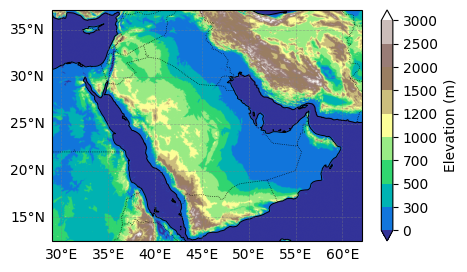

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Open the GeoTIFF ---
dem_path = "../data/arabian_dem.tiff"   # <-- your file
with rasterio.open(dem_path) as src:
    dem = src.read(1, masked=True)  # 2D array of elevation (meters)
    transform = src.transform
    bounds = src.bounds



# --- Get extent for Cartopy (lon/lat) ---
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# --- Plot ---
fig, ax = plt.subplots(figsize=(5, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# --- Define discrete bins and colormap ---
bounds = [ 0, 300, 500, 700, 1000, 1200, 1500, 2000, 2500, 3000]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.cm.terrain.N, extend='both')

# --- Plot DEM ---
im = ax.imshow(
    dem,
    origin="upper",
    extent=extent,
    cmap="terrain",
    norm=norm,
    transform=ccrs.PlateCarree()
)

# --- Colorbar ---
cbar = plt.colorbar(
    im,
    ax=ax,
    shrink=0.5,
    pad=0.05,
    boundaries=bounds,
    ticks=bounds
)
cbar.set_label("Elevation (m)")
# Add coastlines and borders
ax.coastlines(resolution="50m", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
#add lat lon gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig('figures/topography.pdf', bbox_inches='tight', dpi=300)
plt.show()


# Annual Rainfall %

In [10]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = '../download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')
#convert T to pd.datetime
obs_3m['T'] = pd.to_datetime(obs_3m['T'].values, format="%d-%m-%Y")

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


C:\Users\emile\AppData\Local\Temp\ipykernel_10832\3681288506.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.05,1,1])


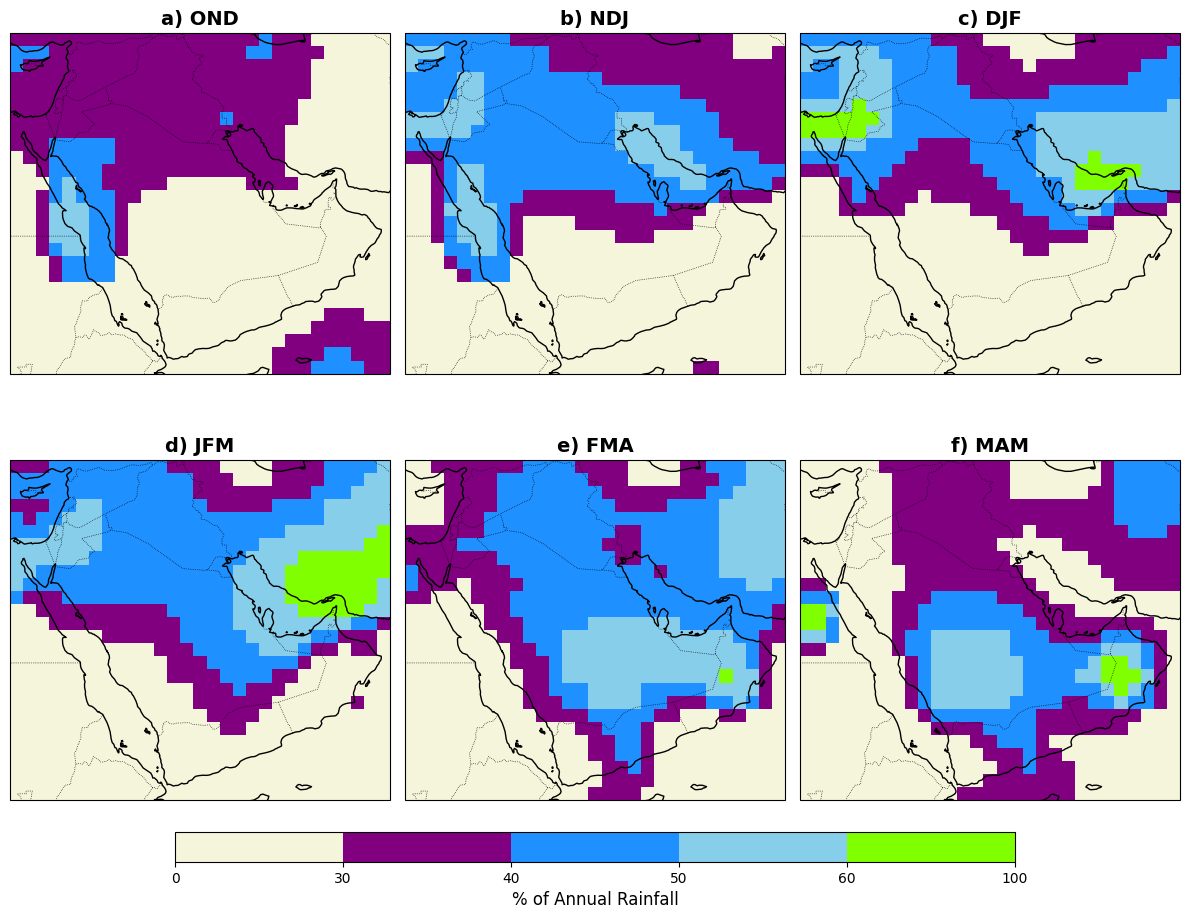

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# --- Setup seasons and panels ---
seasons = ["OND", "NDJ", "DJF", "JFM", "FMA", "MAM"]
season_months = [12, 1, 2, 3, 4, 5]
panel_labels = ["a)","b)","c)","d)","e)","f)"]

# --- Annual total rainfall ---
annual_total = obs.groupby("T.year").sum("T").mean("year")

# --- Compute seasonal % ---
percent_dict = {}
for season, month in zip(seasons, season_months):
    season_mean = obs_3m.sel(T=obs_3m['T.month']==month).mean("T")
    percent_dict[season] = (season_mean / annual_total) * 100

# --- Discrete colormap ---
colors = ["beige", "purple", "dodgerblue", "skyblue", "chartreuse"]
bounds = [0, 30, 40, 50, 60, 100]   # thresholds
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# --- Create 3x2 panels ---
fig, axes = plt.subplots(2, 3, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    im = percent_dict[season].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        add_colorbar=False
    )
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_title(f"{panel_labels[i]} {season}", fontsize=14, fontdict={'weight': 'bold'})

# --- Common discrete colorbar at bottom ---
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=bounds)
cbar.set_label("% of Annual Rainfall", fontsize=12)
cbar.set_ticks(bounds)  # show thresholds
cbar.ax.set_xticklabels(["0","30","40","50","60","100"])
plt.tight_layout(rect=[0,0.05,1,1])
plt.savefig('figures/annual_rainfall_percentage.pdf', bbox_inches='tight', dpi=150)
plt.show()


# Fig 2 - Density

In [22]:
periods = {
    '1981-2000': slice('1981-01-01', '2000-12-31'),
    '2001-2020': slice('2001-01-01', '2020-12-31'),
    '1981-2020': slice('1981-01-01', '2020-12-31')
}

month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']


# Container: season → period → flattened SPI values
data_for_plot = {season: {} for season in seasons}

for season_idx, season in enumerate(seasons, 1):
    # Select data for this season (month)
    spi_season = spi.sel(time=spi['time'].dt.month == season_idx)

    for period_name, time_slice in periods.items():
        spi_period = spi_season.sel(time=time_slice).mean(['time'])

        # Flatten all grid cells and times for KDE
        values = spi_period.values.flatten()
        values = values[~np.isnan(values)]

        data_for_plot[season][period_name] = values


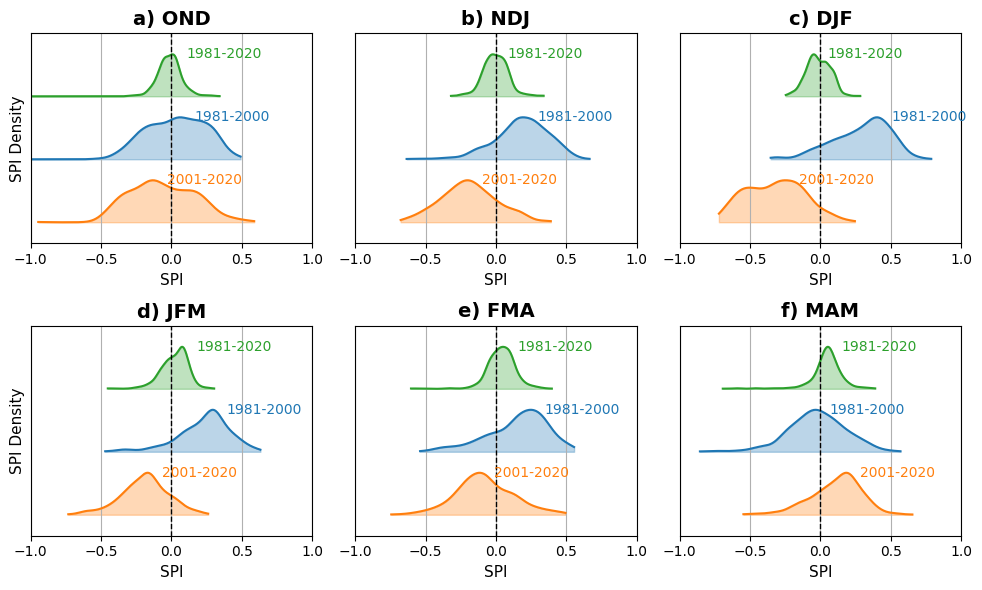

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# New periods order and colors with reversed vertical order for plotting
periods_order = ['1981-2020', '1981-2000', '2001-2020']
colors = ['tab:green', 'tab:blue', 'tab:orange']
offsets = [3, 1.5, 0]

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, season in enumerate(seasons):
    ax = axes[i]
    max_density = 0
    
    for offset, period_name, color in zip(offsets, periods_order, colors):
        data = data_for_plot[season][period_name]
        
        if len(data) < 10:
            continue
        
        kde = gaussian_kde(data)
        xs = np.linspace(np.min(data), np.max(data), 200)
        ys = kde(xs)
        ys_scaled = ys / ys.max() + offset
        
        ax.plot(xs, ys_scaled, color=color)
        ax.fill_between(xs, offset, ys_scaled, color=color, alpha=0.3)
        
        # Add period label inside the plot next to the right end of the KDE
        x_text = xs[np.argmax(ys_scaled)] + 0.1
        y_text = ys_scaled[np.argmax(ys_scaled)]
        ax.text(x_text, y_text, period_name, color=color, fontsize=10, va='center')

        max_density = max(max_density, ys_scaled.max())

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    
    ax.set_yticks([])  # remove y-axis labels completely
    ax.set_ylim(-0.5, max_density + 0.5)
    ax.set_xlabel('SPI', fontsize=11)
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    ax.grid(True, axis='x')

    ax.set_xlim(-1, 1)
    
    if i % 3 == 0:
        ax.set_ylabel('SPI Density', fontsize=11)

# Turn off unused axes
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/fig_kde.pdf', dpi=300)
plt.show()

# Suppl

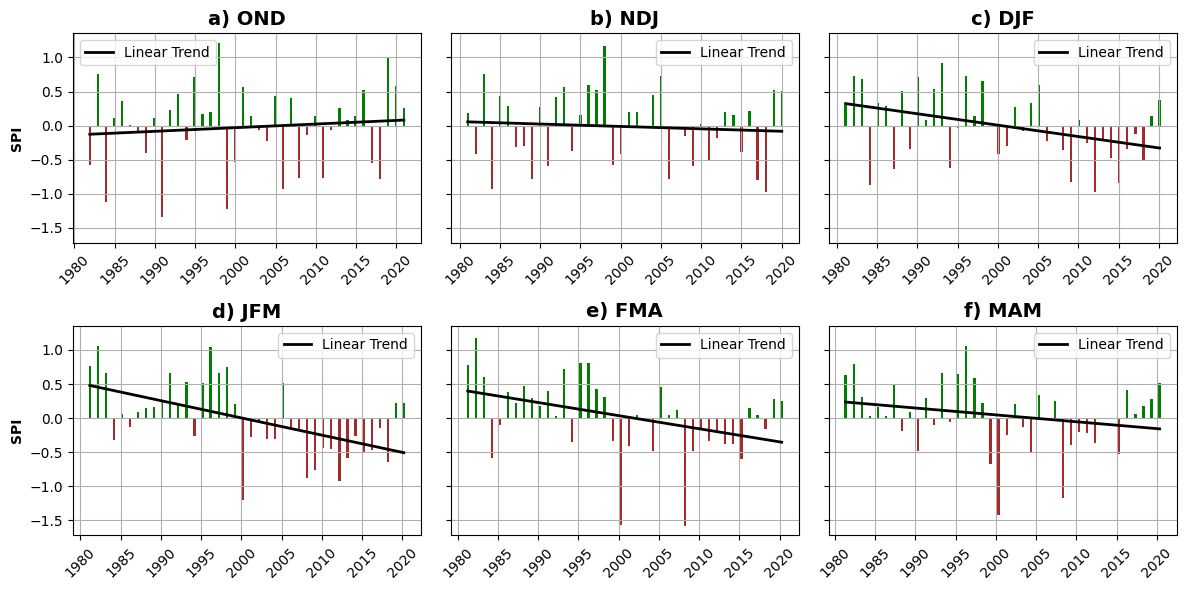

In [24]:
# Your selected seasons (replace with your actual 6 selected seasons)
selected_seasons = ['OND', 'NDJ','DJF', 'JFM', 'FMA', 'MAM']

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.flatten()

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']  # Label prefixes

for i, season in enumerate(selected_seasons):
    ax = axes[i]
    
    # month_to_season mapping
    month_to_season = {
        1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
        5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
        9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
    }
    
    # Get months for the current season
    months_in_season = [m for m, s in month_to_season.items() if s == season]
    
    # Filter spi data for these months
    spi_season = spi.sel(time=spi['time'].dt.month.isin(months_in_season))
    
    # Compute spatial average over domain for selected months & times
    spi_avg = spi_season.mean(dim=['lat', 'lon'])
    
    times = pd.to_datetime(spi_avg['time'].values)
    values = spi_avg.values
    
    # Linear regression
    time_numeric = np.arange(len(times))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, values)
    trend_line = intercept + slope * time_numeric
    
    # Bar colors by sign
    colors = ['green' if v > 0 else 'brown' for v in values]
    
    # Plot bars and trend
    ax.bar(times, values, color=colors, width=100, align='center')
    ax.plot(times, trend_line, color='black', linewidth=2, label='Linear Trend')
    
    # Title with prefix label
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    
    if i % 3 == 0:
        ax.set_ylabel('SPI',fontweight='bold')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45, labelsize=10)

# Hide unused axes if any
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/suppfig_ts_bar.pdf', dpi=300)
plt.show()

# Fig Teleco SLP

In [26]:

#NOAA COBE SST data
sst = xr.open_dataset('../data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))
#select enso region
sst = sst.sel(lat=slice(30, -30), lon=slice(140, 290))


In [30]:
os.makedirs('figures/telecos', exist_ok=True)

In [31]:
def svd_analysis(left, right, n_modes=1, month=None, label=None, left_var="SST", right_var='SPI',land_mask=mask,
                 left_proj=ccrs.PlateCarree(central_longitude=150), right_proj = ccrs.PlateCarree(), detrend=False):


    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        left = left.sel(time=left['time.month'] == month_num)
        right = right.sel(time=right['time.month'] == month_num)
    right_mask = (right.isel(time=0).notnull().values) & (land_mask == 0)

    if right_var == 'SPI':
        right = right.where(right_mask)

    if detrend:
        def xr_detrend(da):
            return xr.apply_ufunc(
                scipy_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[da.dtype]
            )
        left = xr_detrend(left.fillna(0)).transpose('time','lat','lon')
        right = xr_detrend(right.fillna(0)).transpose('time','lat','lon')

    left = (left - left.mean(dim='time', skipna=True)) / (left.std(dim='time', skipna=True) + 1e-6)
    right = (right - right.mean(dim='time', skipna=True)) / (right.std(dim='time', skipna=True) + 1e-6)

    mca = xMCA(left.fillna(0), right.fillna(0))
    mca.apply_coslat()
    mca.solve()


    X = left.fillna(0)
    Y = right.fillna(0)



    if month is not None:
        mca.set_field_names(f'{left_var} ({month})', f'{right_var} ({month})')
    else:
        mca.set_field_names({left_var}, {right_var})

    # --- ADDED: helper to compute Pearson r and p-value per gridcell
    from scipy.stats import pearsonr
    def correlate_grid_with_pval(grid_data, pc):
        """
        grid_data: DataArray (time, lat, lon)
        pc: DataArray (time,) aligned in time with grid_data
        Returns (corr_da, pval_da) as DataArray (lat, lon)
        """
        lats = grid_data['lat'].values
        lons = grid_data['lon'].values
        corr = np.full((len(lats), len(lons)), np.nan)
        pval = np.full((len(lats), len(lons)), np.nan)

        pc_vals = pc.values
        for i in range(len(lats)):
            for j in range(len(lons)):
                ts_da = grid_data.isel(lat=i, lon=j)
                ts = ts_da.values

                if ts.shape[0] != pc_vals.shape[0]:
                    try:
                        ts = ts_da.sel(time=pc['time']).values
                    except Exception:
                        continue

                mask = np.isfinite(ts) & np.isfinite(pc_vals)
                if np.sum(mask) < 3:
                    continue

                ts_masked = ts[mask]
                pc_masked = pc_vals[mask]

                # Skip if constant (all same value)
                if np.all(ts_masked == ts_masked[0]) or np.all(pc_masked == pc_masked[0]):
                    continue

                try:
                    r, p = pearsonr(pc_masked, ts_masked)
                except Exception:
                    r, p = np.nan, np.nan

                corr[i, j] = r
                pval[i, j] = p

        corr_da = xr.DataArray(corr, coords=[lats, lons], dims=['lat', 'lon'])
        pval_da = xr.DataArray(pval, coords=[lats, lons], dims=['lat', 'lon'])
        return corr_da, pval_da
    # --- END ADDED


    table = []
    for i in range(n_modes):
        fig = plt.figure(figsize=(18, 6))

                # Rank-1 reconstructions
        X_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['left']
        Y_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['right']

        # Total and explained variance
        total_var_X = np.sum(np.var(X, axis=0, ddof=1))
        total_var_Y = np.sum(np.var(Y, axis=0, ddof=1))
        explained_var_X = np.sum(np.var(X_recon, axis=0, ddof=1))
        explained_var_Y = np.sum(np.var(Y_recon, axis=0, ddof=1))

        frac_var_left = explained_var_X / total_var_X
        frac_var_right = explained_var_Y / total_var_Y


        left_map = mca.eofs()['left'].sel(mode=i+1)
        right_map = mca.eofs()['right'].sel(mode=i+1)
        right_map = right_map.where(right_mask)

        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()
        r_val = np.corrcoef(left_pcs.values, right_pcs.values)[0, 1]

                # Use PCs
        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)

        # Normalize PCs
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()

        # Align time for correlation
        left = left.sel(time=left_pcs['time'])
        right = right.sel(time=right_pcs['time'])

        # Grid-wise correlation between PC and gridcell time series
        # --- REPLACED: compute correlation AND p-values with helper above
        left_map, left_pval = correlate_grid_with_pval(left, right_pcs)
        right_map, right_pval = correlate_grid_with_pval(right, left_pcs)
        # --- END REPLACEMENT

        # Mask invalid areas
        right_map = right_map.where(right_mask)
        left_map = left_map.where(~np.isnan(left.isel(time=0)))
        right_map = right_map.where(~np.isnan(right.isel(time=0)))

        explained_covar = mca.explained_variance()[i] / 100

        nino_lat_bounds = (5, -5)     # Latitude bounds
        nino_lon_bounds = (170, 240)  # Longitude bounds in 0-360



        # Subset and compute average anomaly over Nino3.4 region
        nino34_anom = left_map.sel(
        lon=slice(nino_lon_bounds[0], nino_lon_bounds[1]),
        lat=slice(nino_lat_bounds[0], nino_lat_bounds[1]))
        


        # Take the mean over time (or specific month if already selected)
        mean_nino34 = nino34_anom.mean()

        # Conditionally flip the sign based on Nino3.4 anomaly
        if mean_nino34 < 0 and left_var == 'SST':
            left_map = -left_map
            right_map = -right_map
            left_pcs = -left_pcs
            right_pcs = -right_pcs
        
        # NAO bounds western africa
        nao_lat_bounds = (20, 0)
        nao_lon_bounds = (-20, 20) 

        # Subset and compute average anomaly over NAO region
        nao_anom = left_map.sel(
        lon=slice(nao_lon_bounds[0], nao_lon_bounds[1]),
        lat=slice(nao_lat_bounds[0], nao_lat_bounds[1]))

        # Take the mean over time (or specific month if already selected)
        mean_nao = nao_anom.mean()

        # Conditionally flip the sign based on NAO anomaly
        if mean_nao <0 and left_var == 'SLP':
             left_map = -left_map
             right_map = -right_map
             left_pcs = -left_pcs
             right_pcs = -right_pcs

        #print table with explaine covariance and explaine variance and pc time series correlation

        #print(f"Mode {i+1}:")
        #print(f"Explained Variance {left_var}: {frac_var_left:.2%}")
        #print(f"Explained Variance {right_var}: {frac_var_right:.2%}")
        #print(f"Pearson r between PCs: {r_val:.2f}\n")
        #print(f"Explained Covariance: {explained_covar:.1%}\n")

        #save these values in a table

        table.append([i+1, np.round(100*frac_var_left.values,1), np.round(100*frac_var_right.values,1),
                       np.round(r_val,2), np.round(explained_covar.values*100,1)])

        cbar_ticks = [-0.6,-0.5,-0.4, -0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

        cmap_discrete = plt.get_cmap('RdBu_r', len(cbar_ticks)-1)

        #apply nan mask to left_map and right_map
        left_map = left_map.where(~np.isnan(left.isel(time=0)).values)
        right_map = right_map.where(right_mask)



        ax1 = fig.add_subplot(1, 3, 1, projection=left_proj)
        pcm1 = ax1.pcolormesh(
            left_map['lon'], left_map['lat'], left_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete, 
            vmin=-0.6, vmax=0.6
        )
        ax1.coastlines()
        cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar1.set_label(f"{left_var} Corr. - Expl. Var. {frac_var_left:.1%}", fontsize=14, fontweight='bold')
        cbar1.ax.tick_params(labelsize=12)
        cbar1.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax1.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on left map (p > 0.05)
        alpha = 0.05
        try:
            sig_mask_left = (left_pval > alpha).astype(int)
            cs1 = ax1.contourf(
                left_map['lon'], left_map['lat'], sig_mask_left,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs1.collections:
                coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(0.8)     # hatch thickness
        except Exception:
            pass


        ax2 = fig.add_subplot(1, 3, 2)

        ax2.plot(left_pcs['time'], left_pcs, label=left_var, color='darkred', linewidth=2)
        ax2.plot(right_pcs['time'], right_pcs, label=right_var, color='darkblue', linewidth=2)
        ax2.set_title("Time Series", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=14, loc='upper left')
        ax2.tick_params(labelsize=12)
        ax2.grid(True)
        ax2.set_ylim(-3, 3)

        ax2.text(0.95, 0.05, f"Pearson r = {r_val:.2f}",
                transform=ax2.transAxes,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

        
        cmap_discrete_right = plt.get_cmap('BrBG', len(cbar_ticks)-1)


        ax3 = fig.add_subplot(1, 3, 3, projection=right_proj)
        pcm2 = ax3.pcolormesh(
            right_map['lon'], right_map['lat'], right_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete_right,
            vmin=-0.6, vmax=0.6
        )
        ax3.coastlines()
        ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax3.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

        cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar2.set_label(f"{right_var} Corr. - Expl. Var. {frac_var_right:.1%}", fontsize=14, fontweight='bold')
        cbar2.ax.tick_params(labelsize=12)
        cbar2.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax3.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on right map (p > 0.05)
        try:
            sig_mask_right = (right_pval > alpha).astype(int)
            cs3 = ax3.contourf(
                right_map['lon'], right_map['lat'], sig_mask_right,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs3.collections:
                #coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(1.5)     # hatch thickness
        except Exception:
            pass
        # --- END ADDED

        
        title = f"{label} {month} – Explained Covar.: {explained_covar:.1%}"
        plt.suptitle(title, fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if detrend:
            plt.savefig(f'figures/telecos/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)
        else:
            plt.savefig(f'figures/telecos/svd_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)

        #merge pcs in one dataframe
        pcs_df = pd.concat([left_pcs.to_dataframe(), right_pcs.to_dataframe()], axis=1)

        #save pc time series to csv
        if detrend:

            pcs_df.to_csv(f'figures/telecos/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)
        else:
            pcs_df.to_csv(f'figures/telecos/svd_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)



        # Show only for mode 1
        if i == 0:
            plt.show()

        # Always close to free memory
        plt.close()
                
                
    df = pd.DataFrame(
            table,
            columns=["Mode", f"Explained Var {left_var}", f"Explained Var {right_var}", "Pearson r", "Explained Cov"]
            )
            #save table as csv
    if detrend:
        df.to_csv(f'figures/telecos/svd_detrended_{left_var}_{right_var}_{month}_table.csv', index=False)
    else:
        df.to_csv(f'figures/telecos/svd_{left_var}_{right_var}_{month}_table.csv', index=False)


In [32]:

#NOAA COBE SST data
slp = xr.open_dataset('../data/mslp.mon.mean.nc').sortby('time')


slp['slp3m'] = slp['mslp'] + slp['mslp'].shift(time=1) + slp['mslp'].shift(time=2)

#put lon is -180 to 180
slp = slp.assign_coords(lon=(((slp.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
slp = slp.sel(time=slice(spi['time'][0], spi['time'][-1]))

slp = slp.sel(lat=slice(80, 20), lon=slice(-90, 40))

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


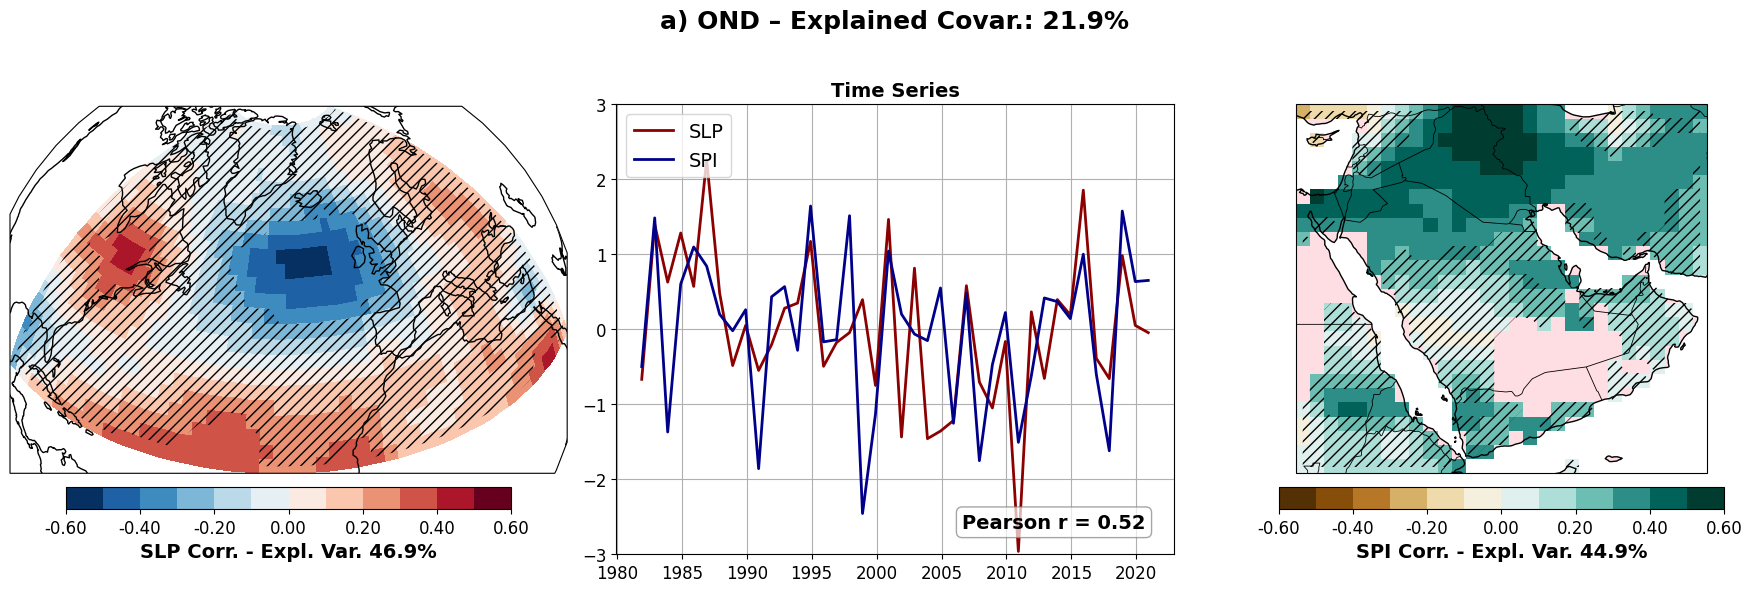

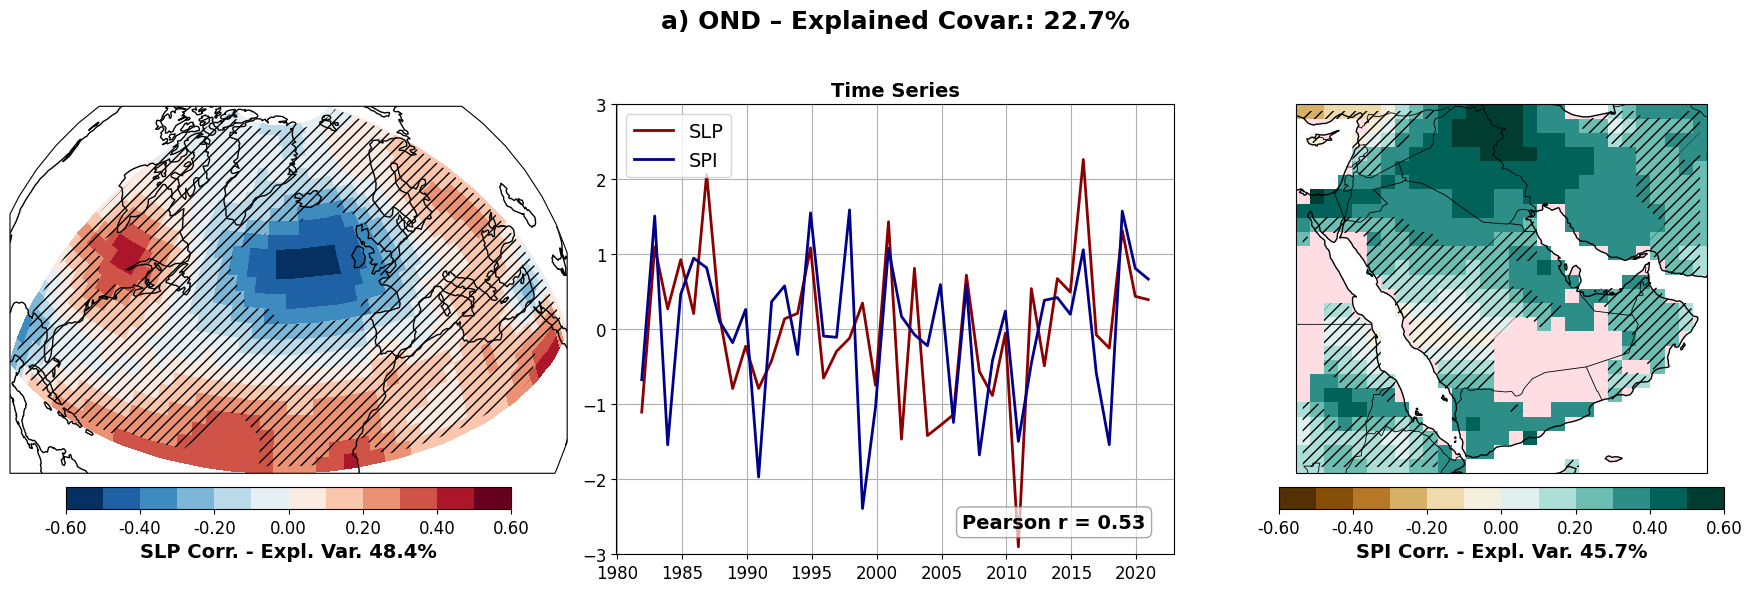

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


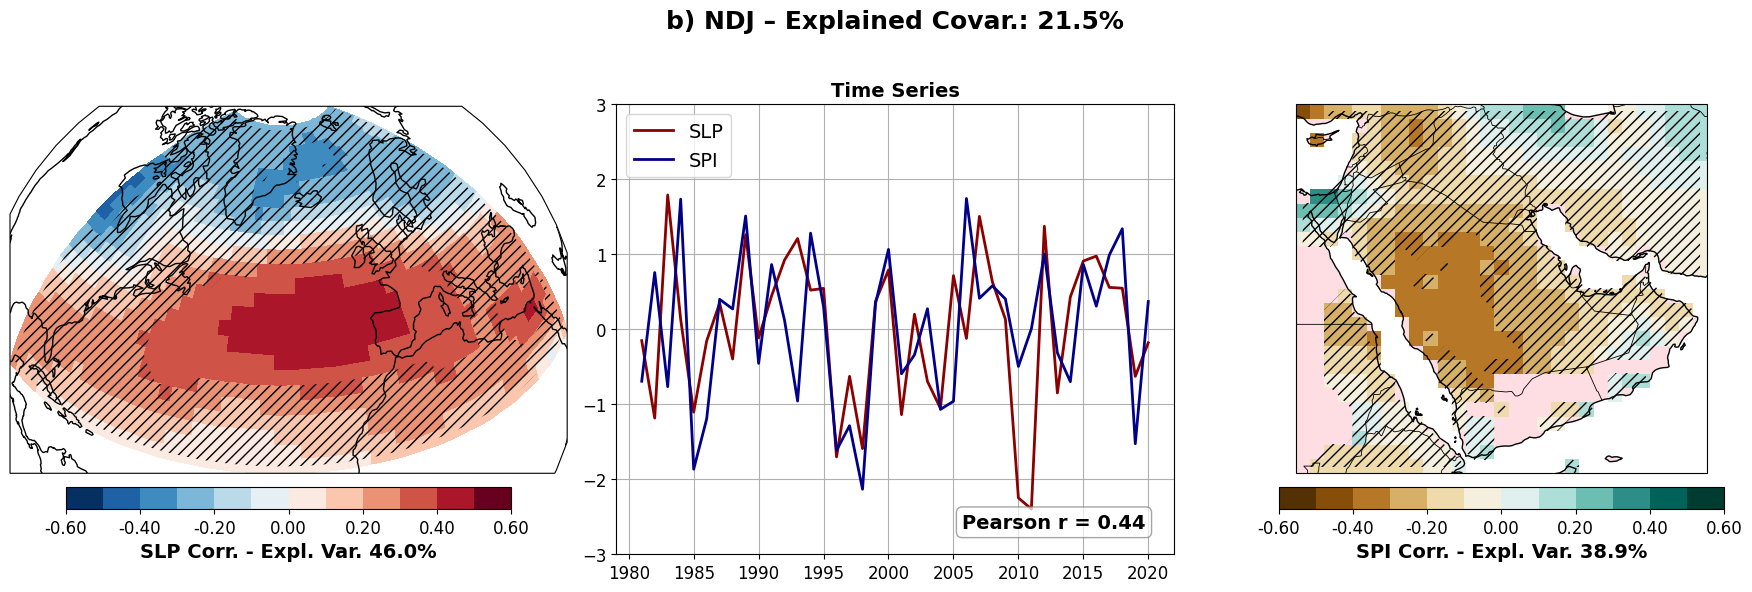

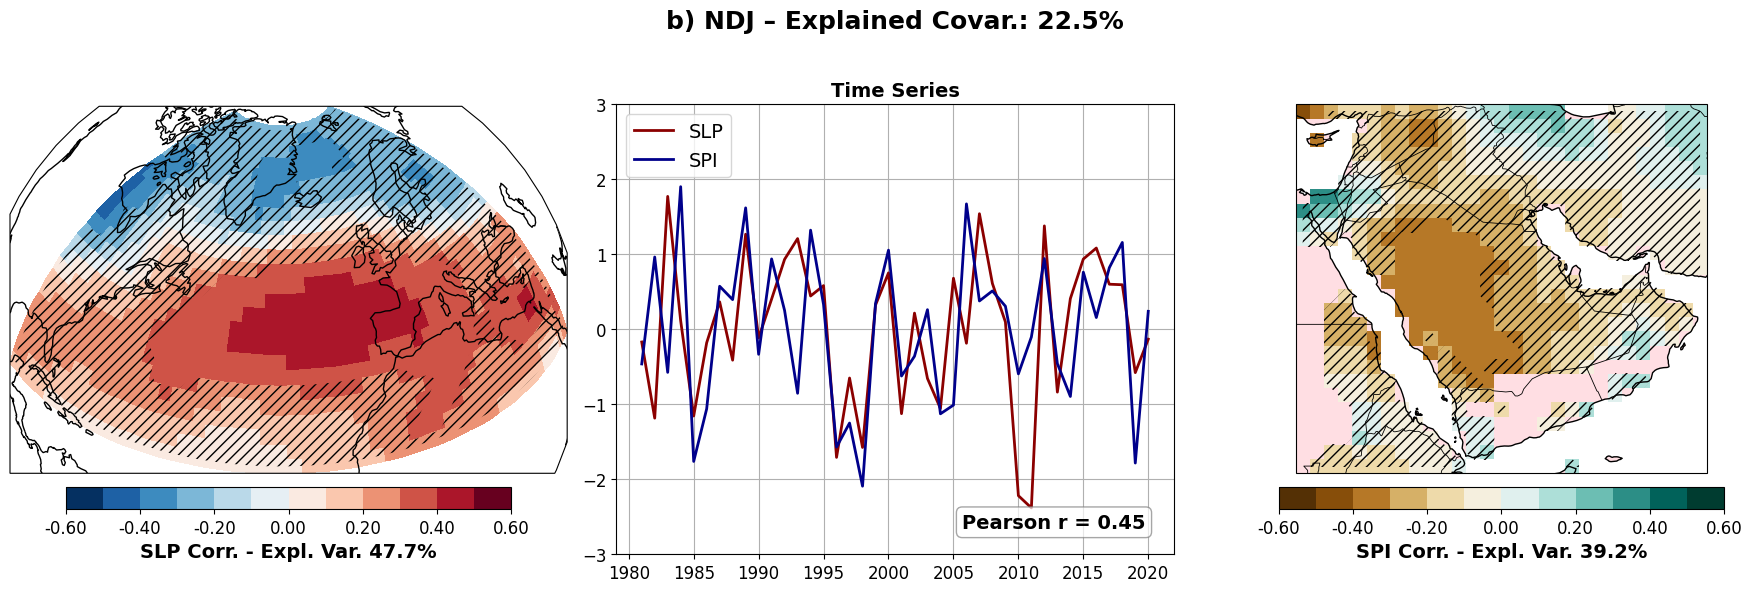

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


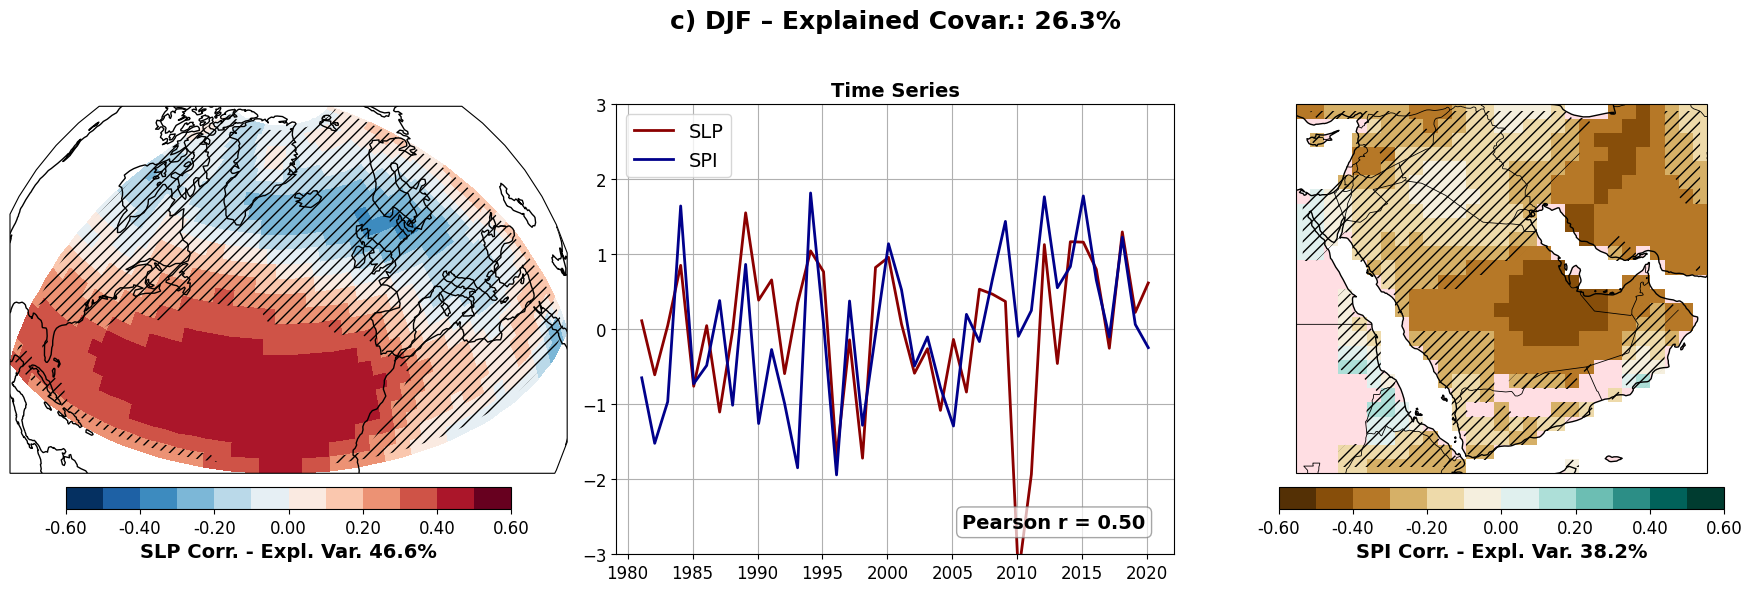

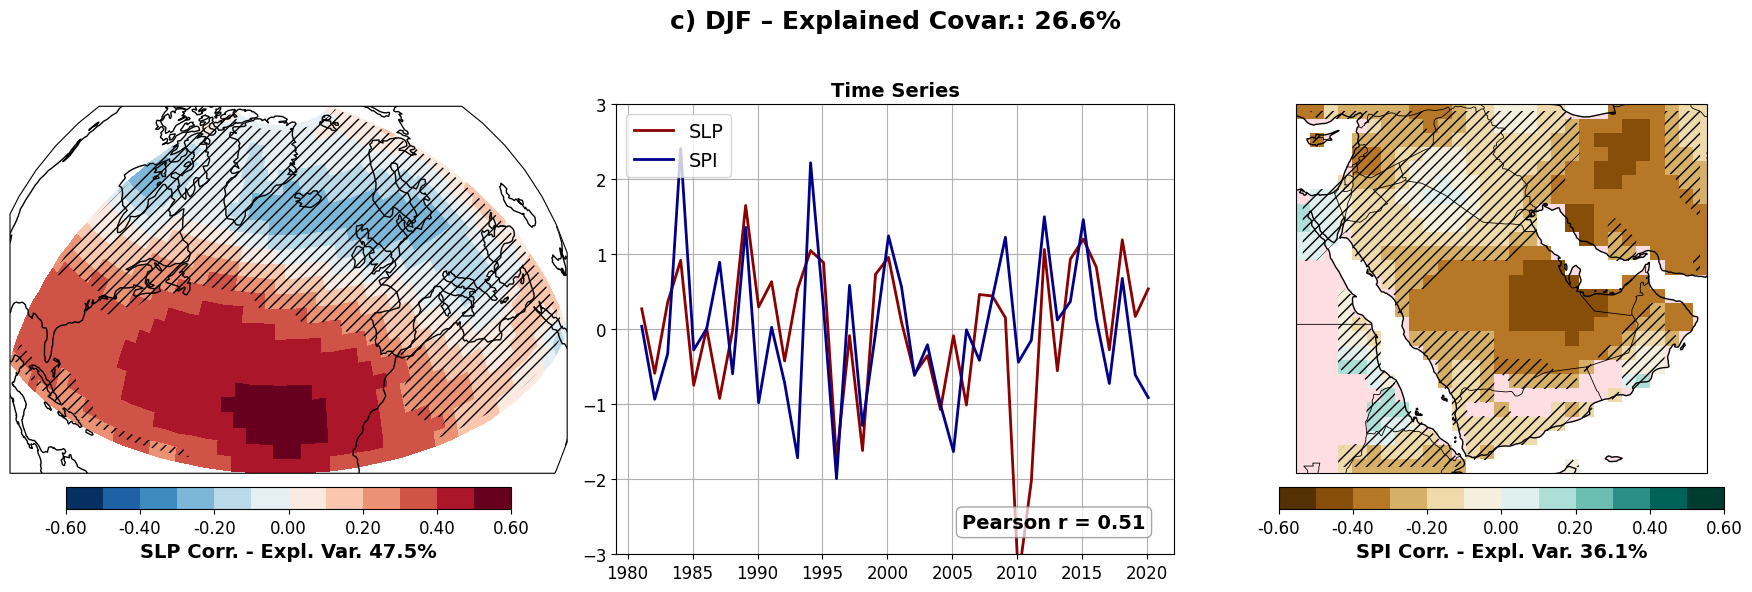

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


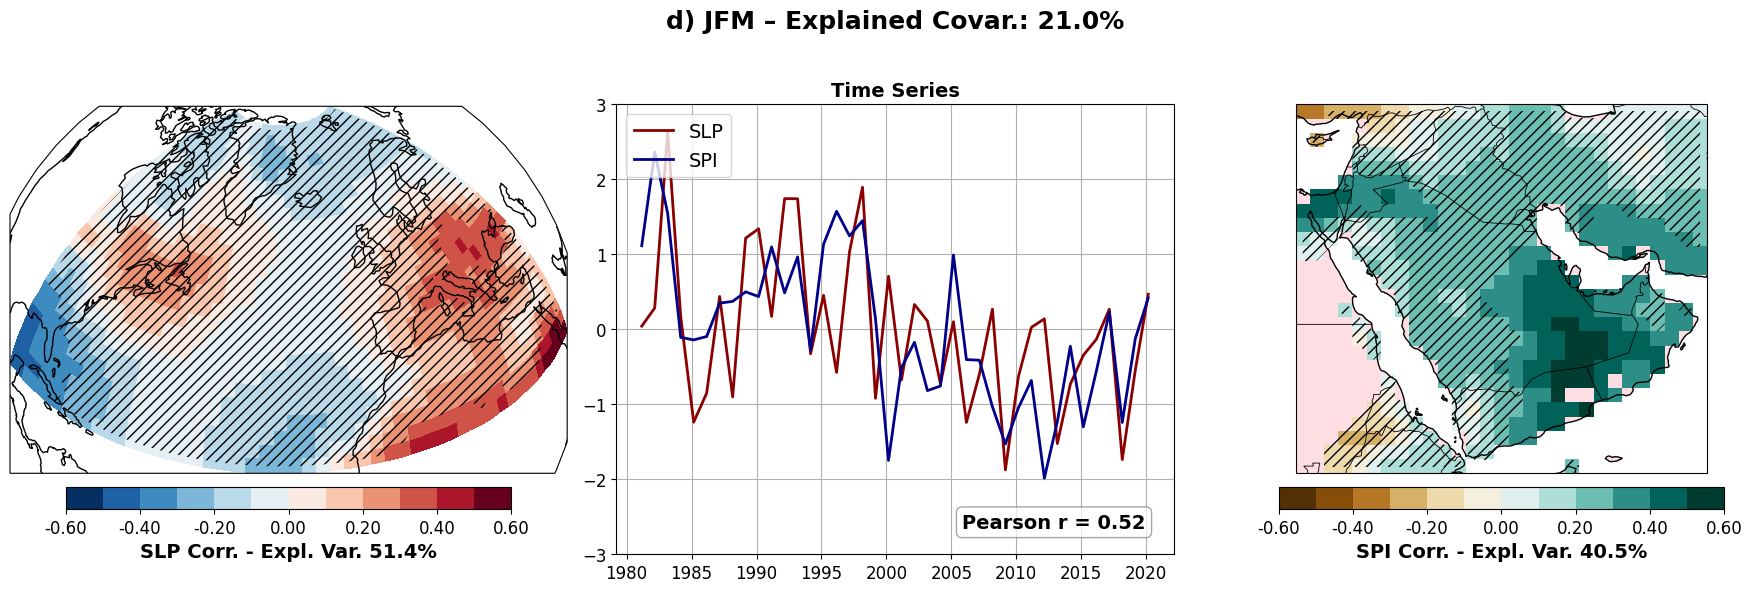

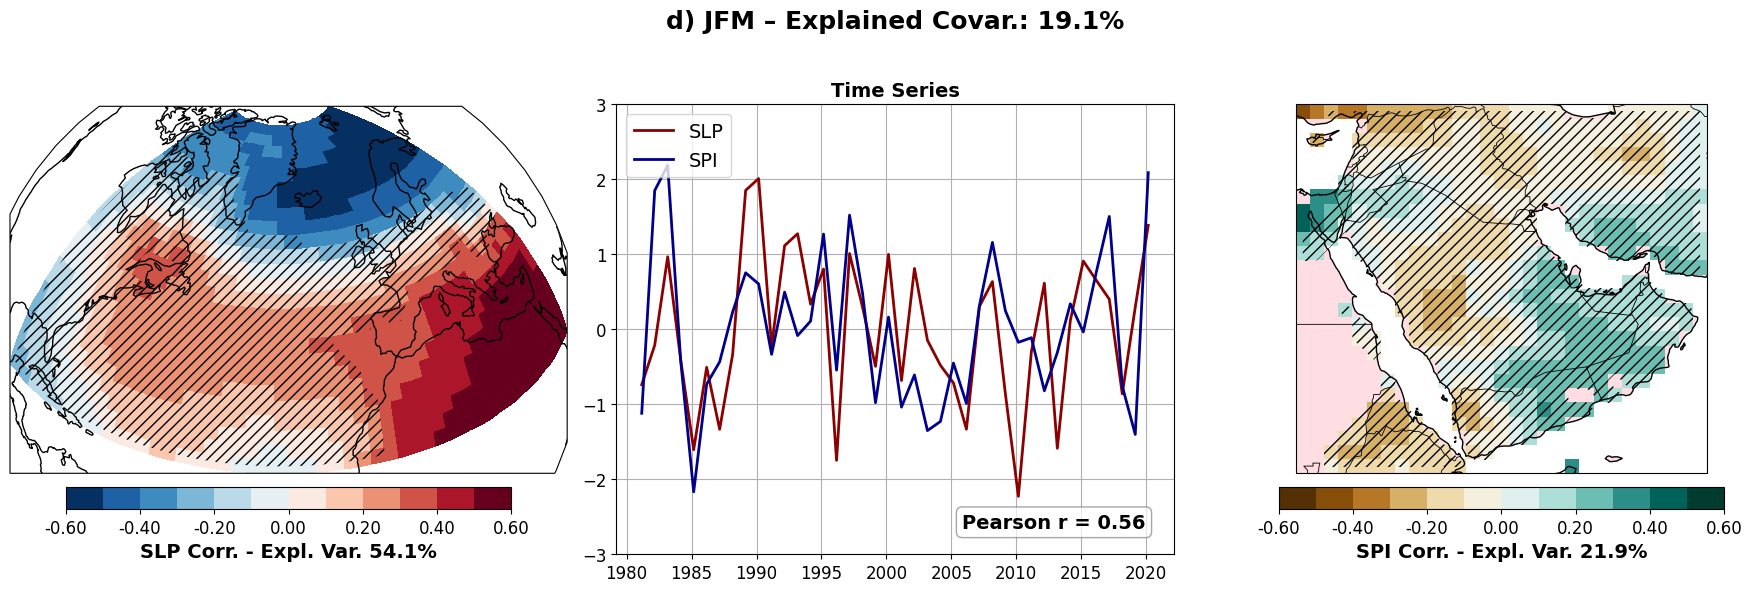

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


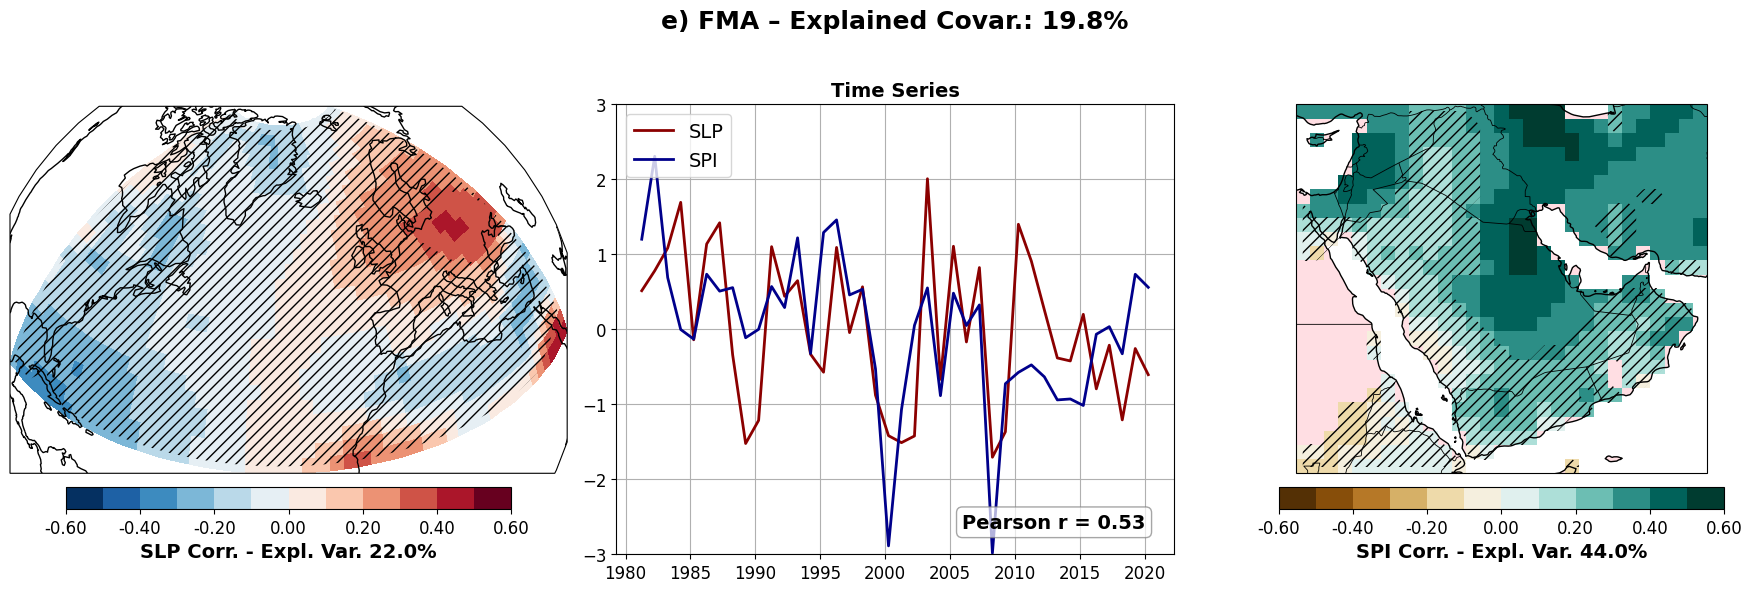

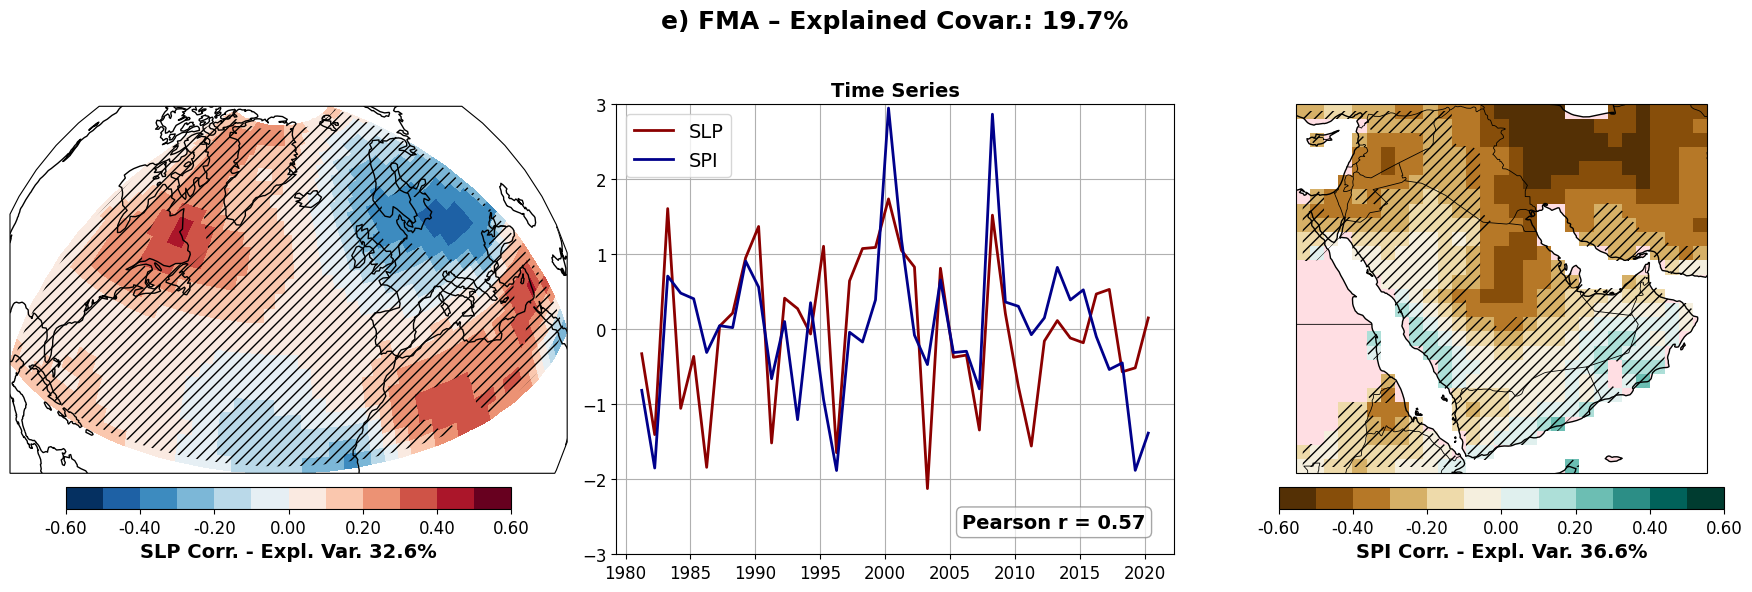

c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


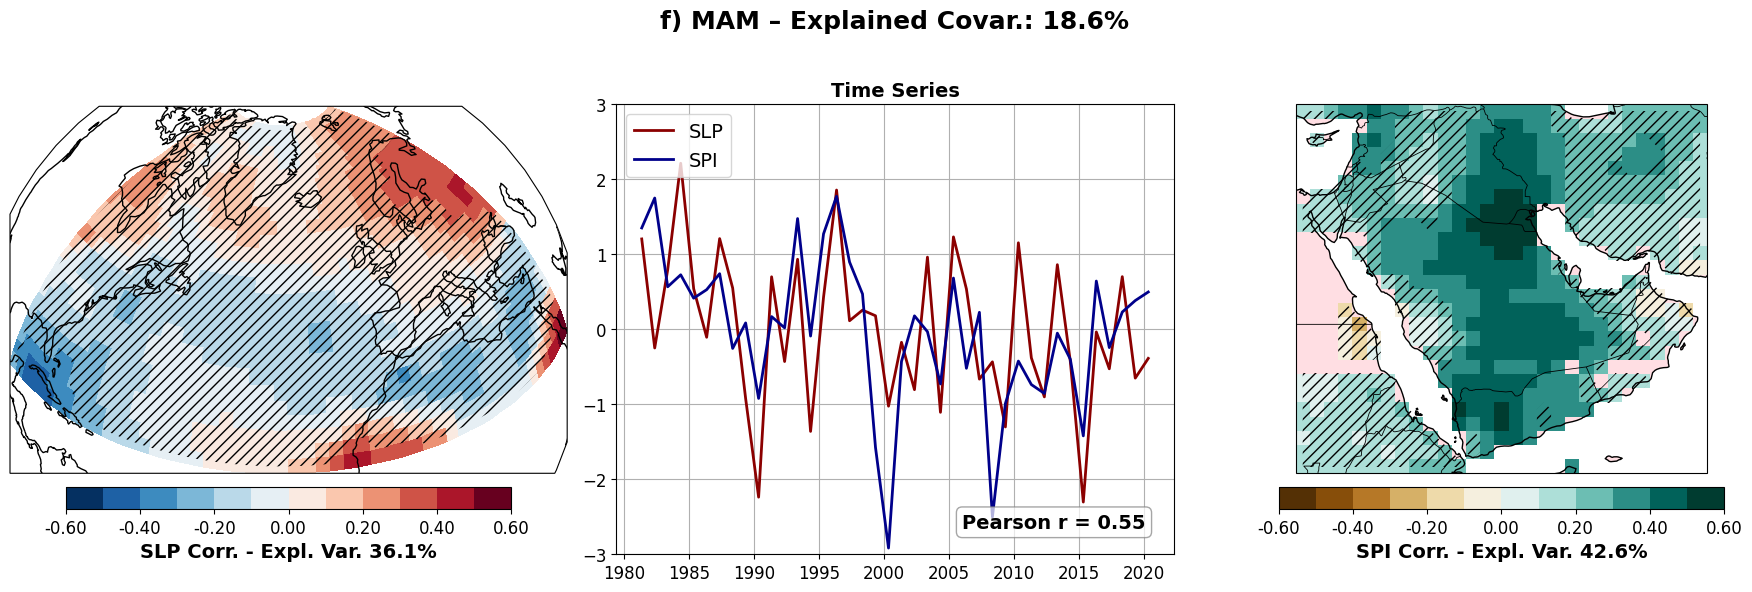

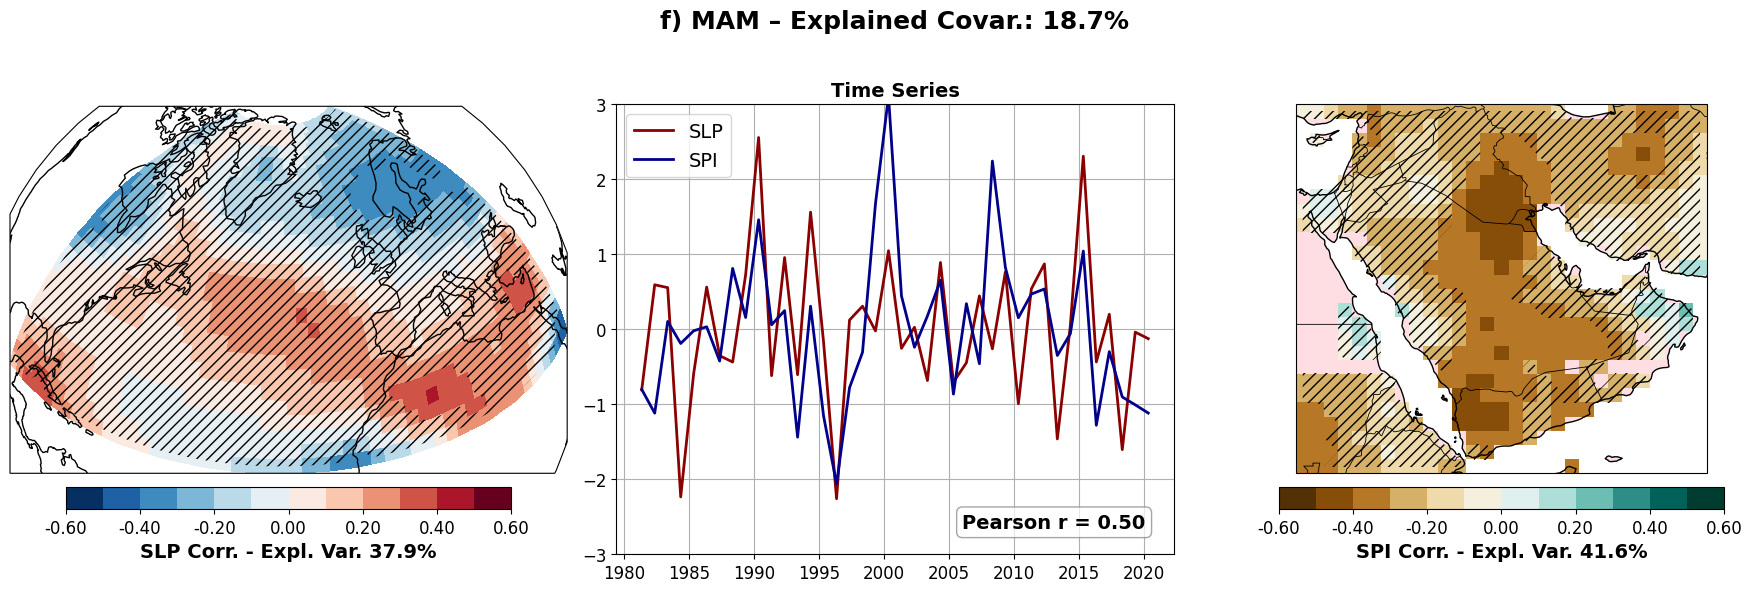

In [33]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    svd_analysis(slp.slp3m,spi,  n_modes=3,
                 month=season, label=label, left_var='SLP',
                 left_proj=ccrs.NearsidePerspective(central_longitude=-30, central_latitude=40))
    svd_analysis(slp.slp3m, spi, n_modes=3,
                 month=season, label=label, left_var='SLP',
                  left_proj=ccrs.NearsidePerspective(central_longitude=-30, central_latitude=40), detrend=True)

# PDO Teleco

In [35]:
#NOAA COBE SST data
sst = xr.open_dataset('../data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))

pdo_sst = sst.sel(lat=slice(80, 20), lon=slice(120, 250))  # 120E–110W (wraps Pacific)

Processing season: OND 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


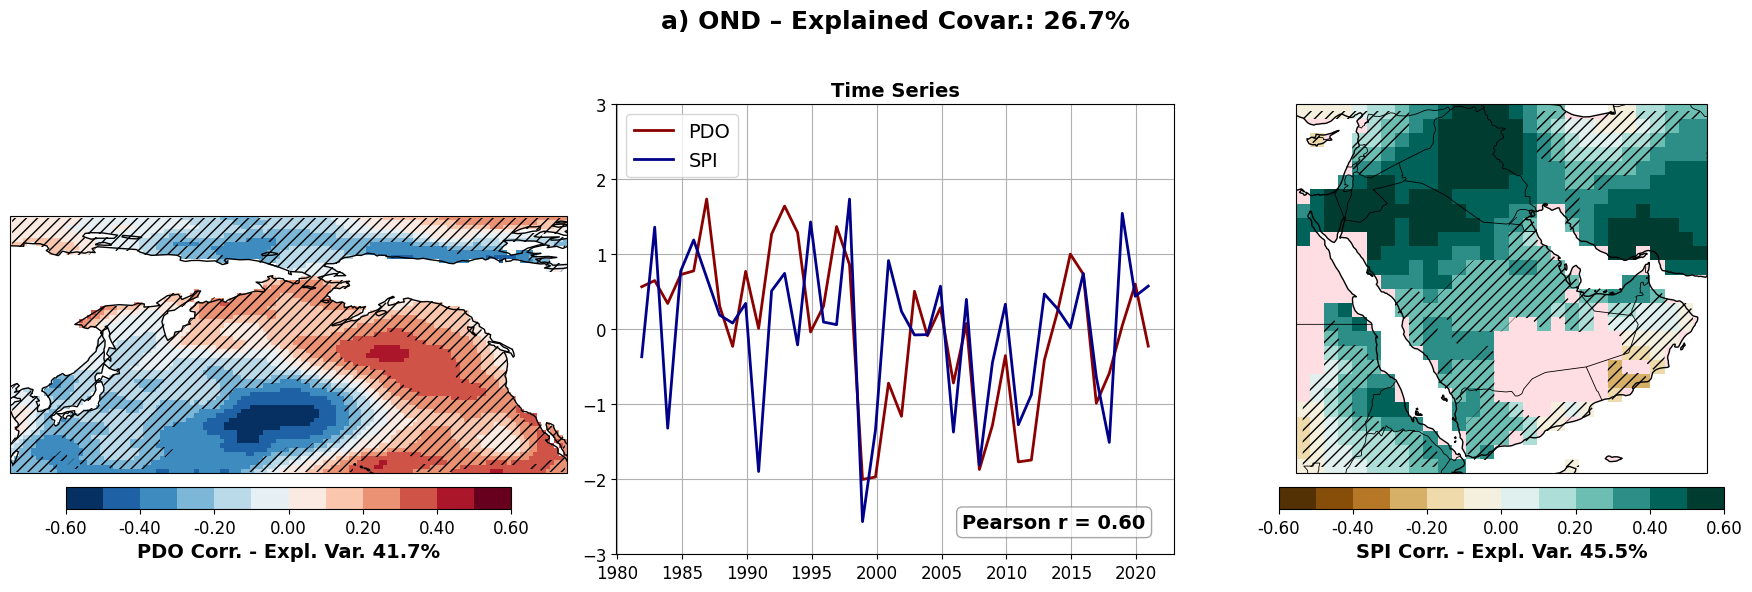

Processing season: OND with detrending


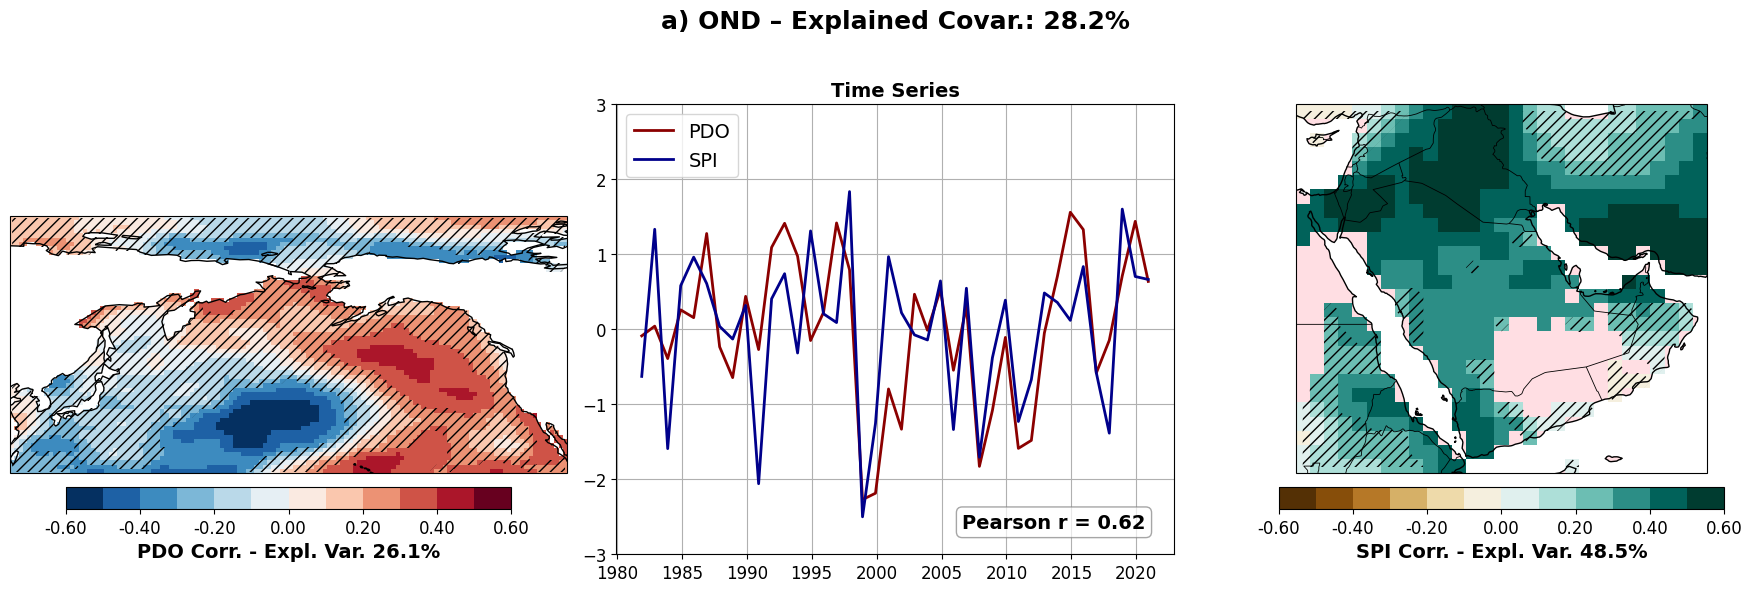

Processing season: NDJ 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


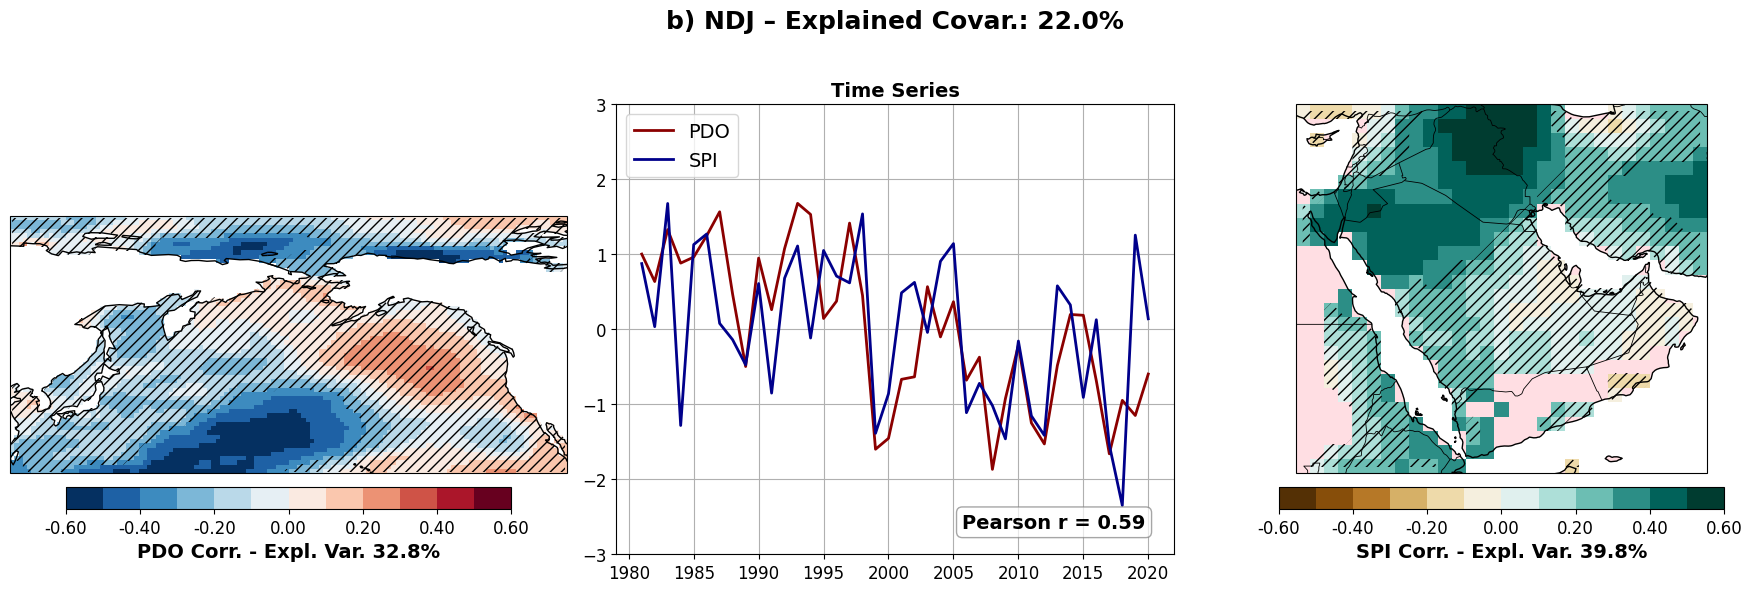

Processing season: NDJ with detrending


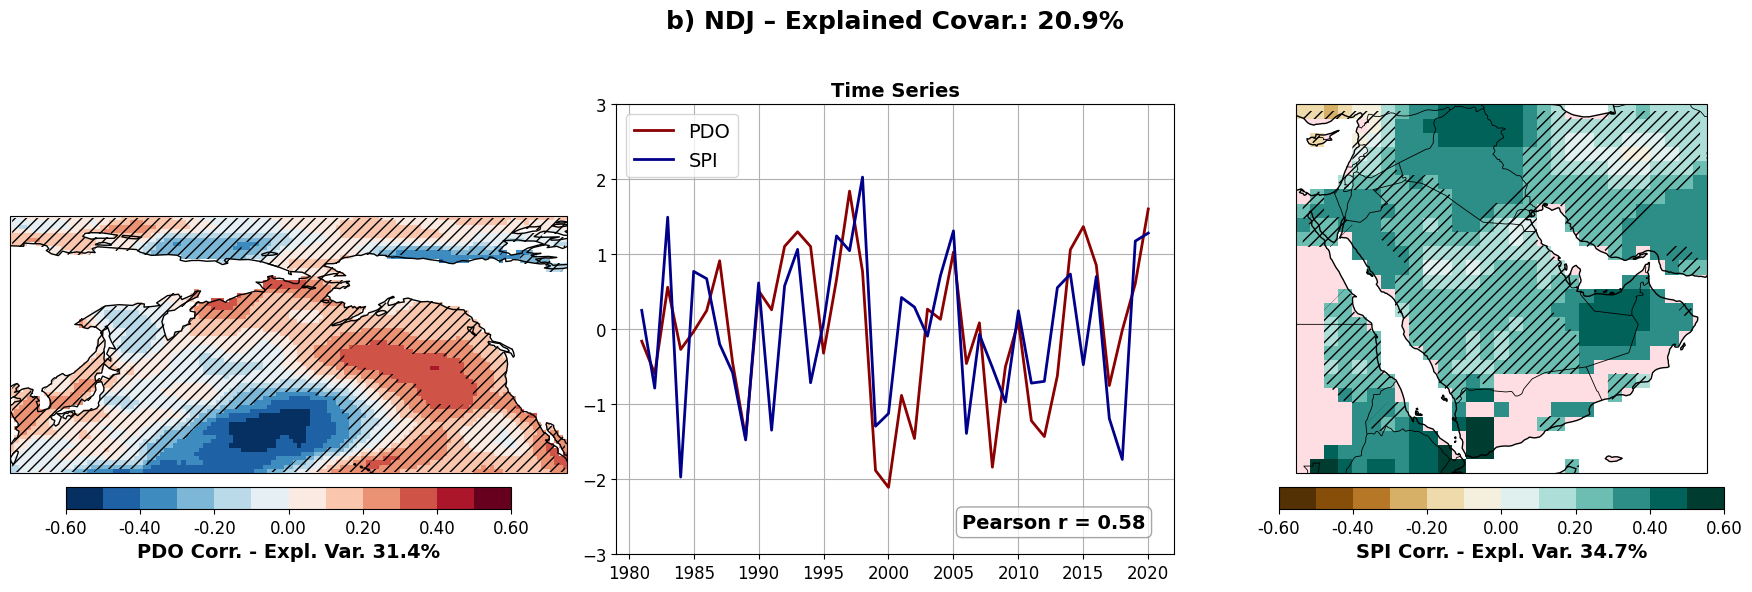

Processing season: DJF 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


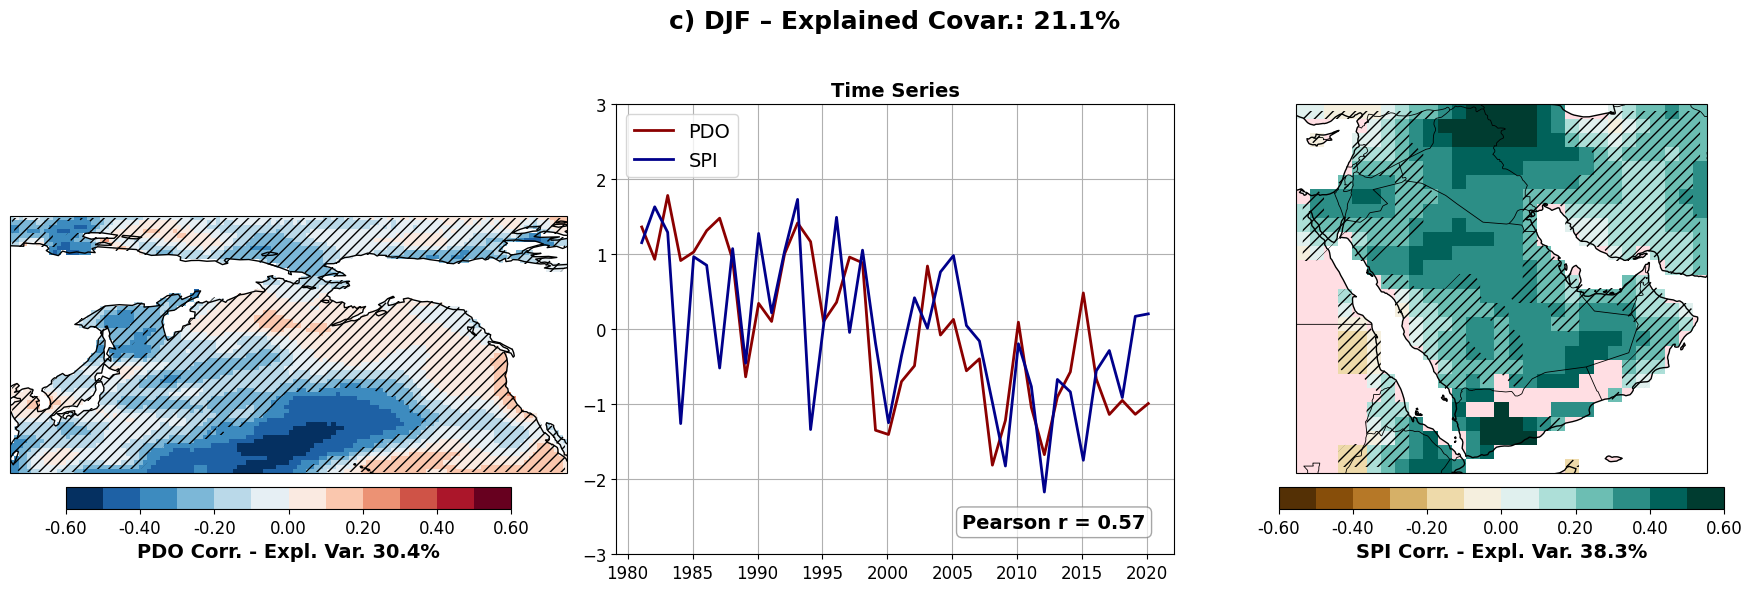

Processing season: DJF with detrending


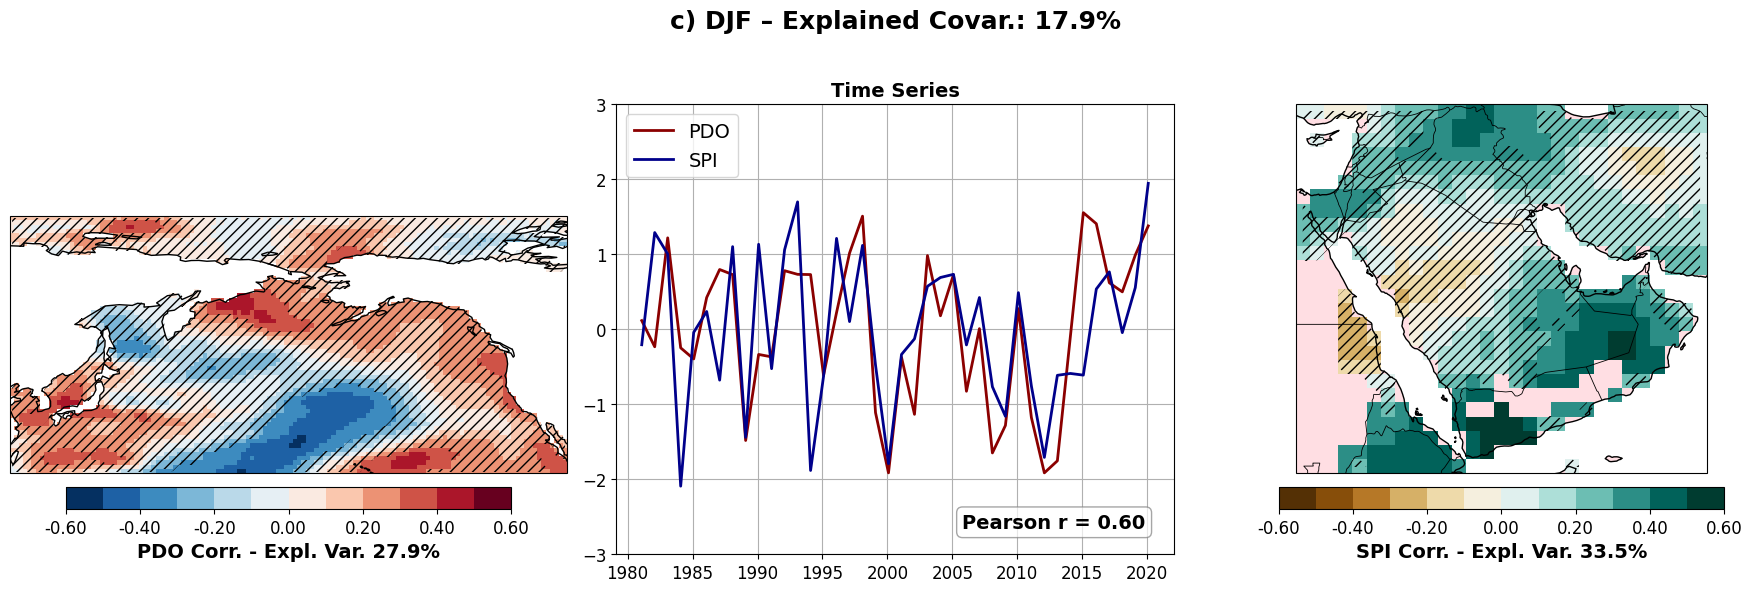

Processing season: JFM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


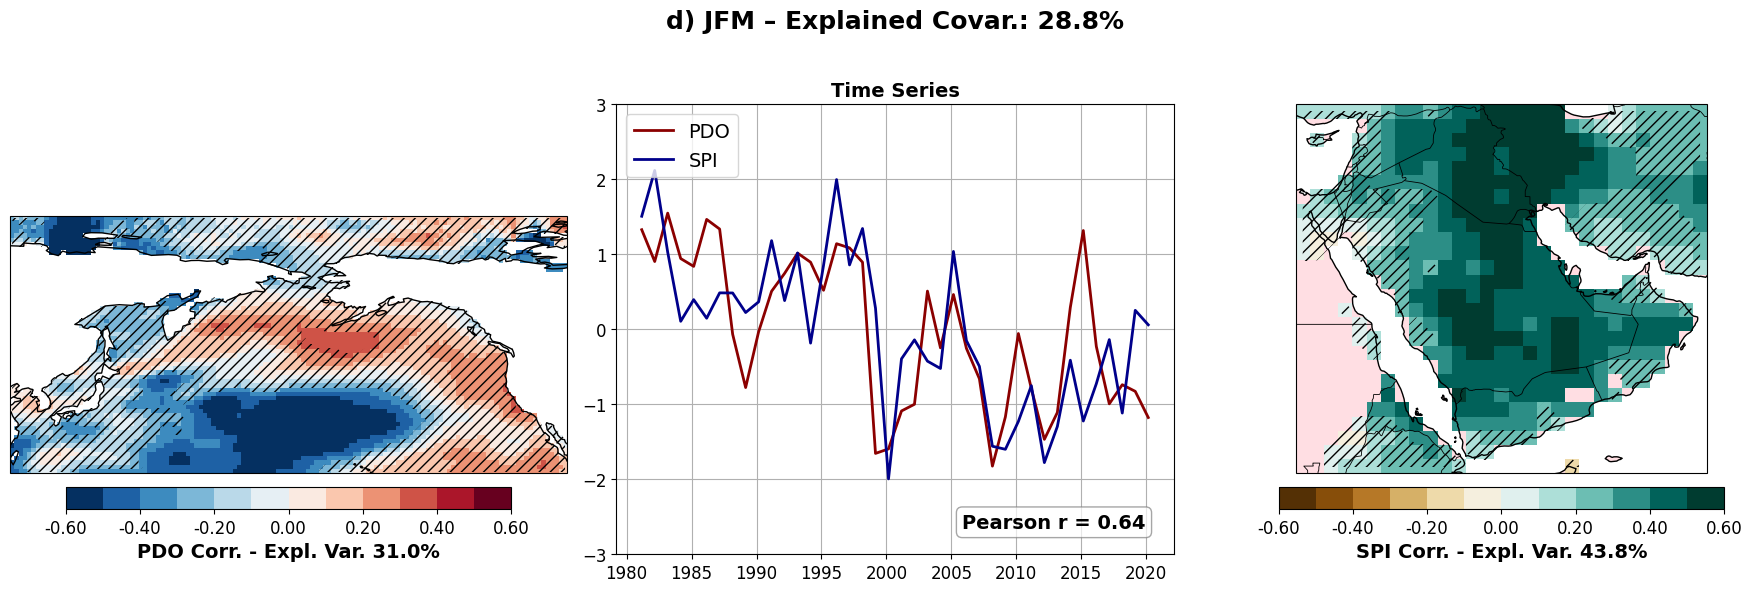

Processing season: JFM with detrending


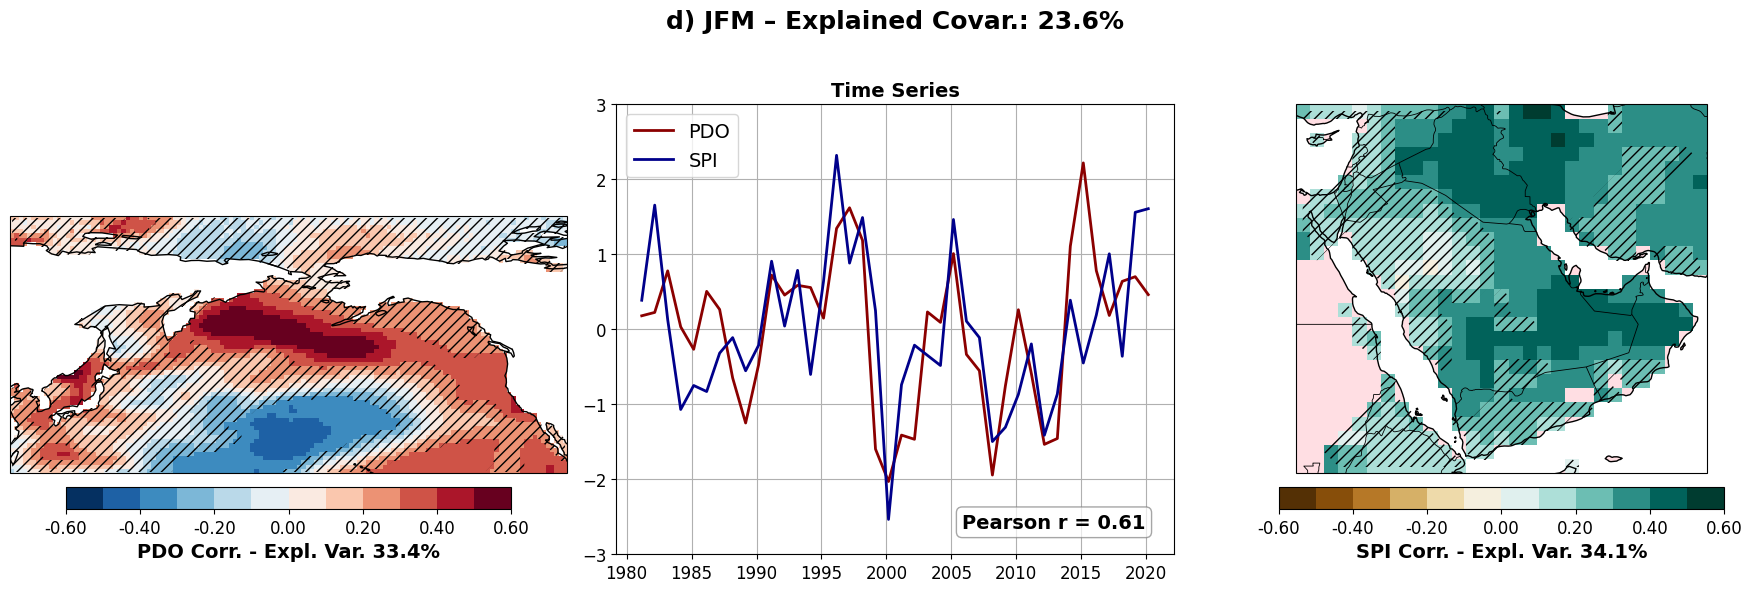

Processing season: FMA 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


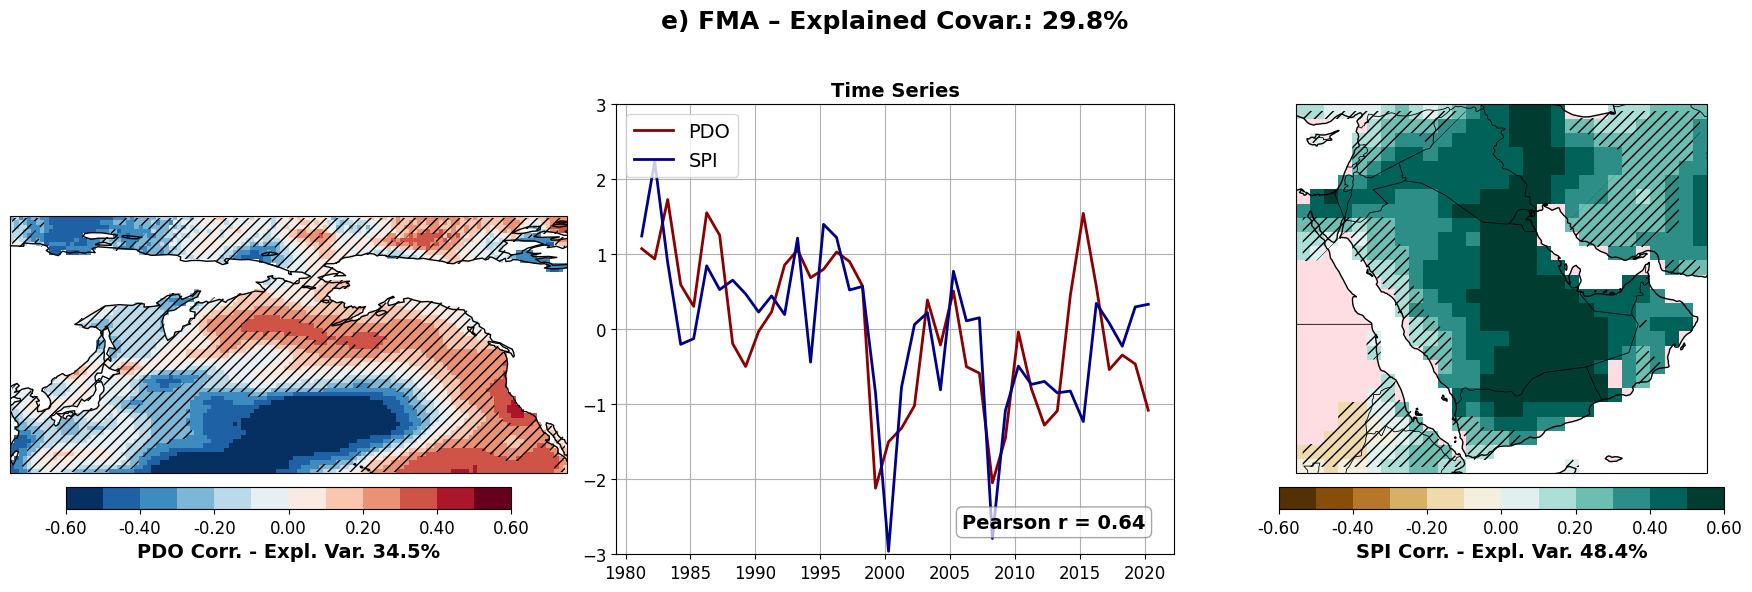

Processing season: FMA with detrending


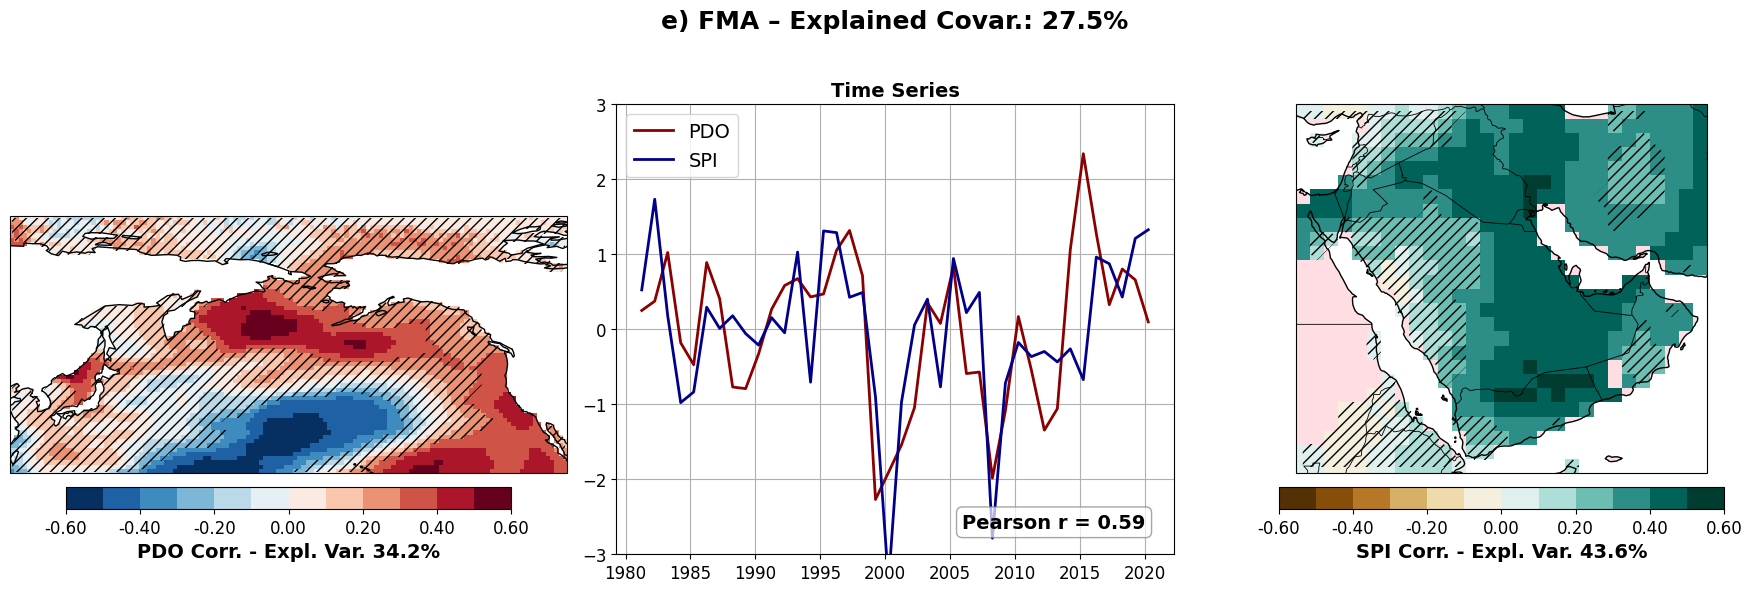

Processing season: MAM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


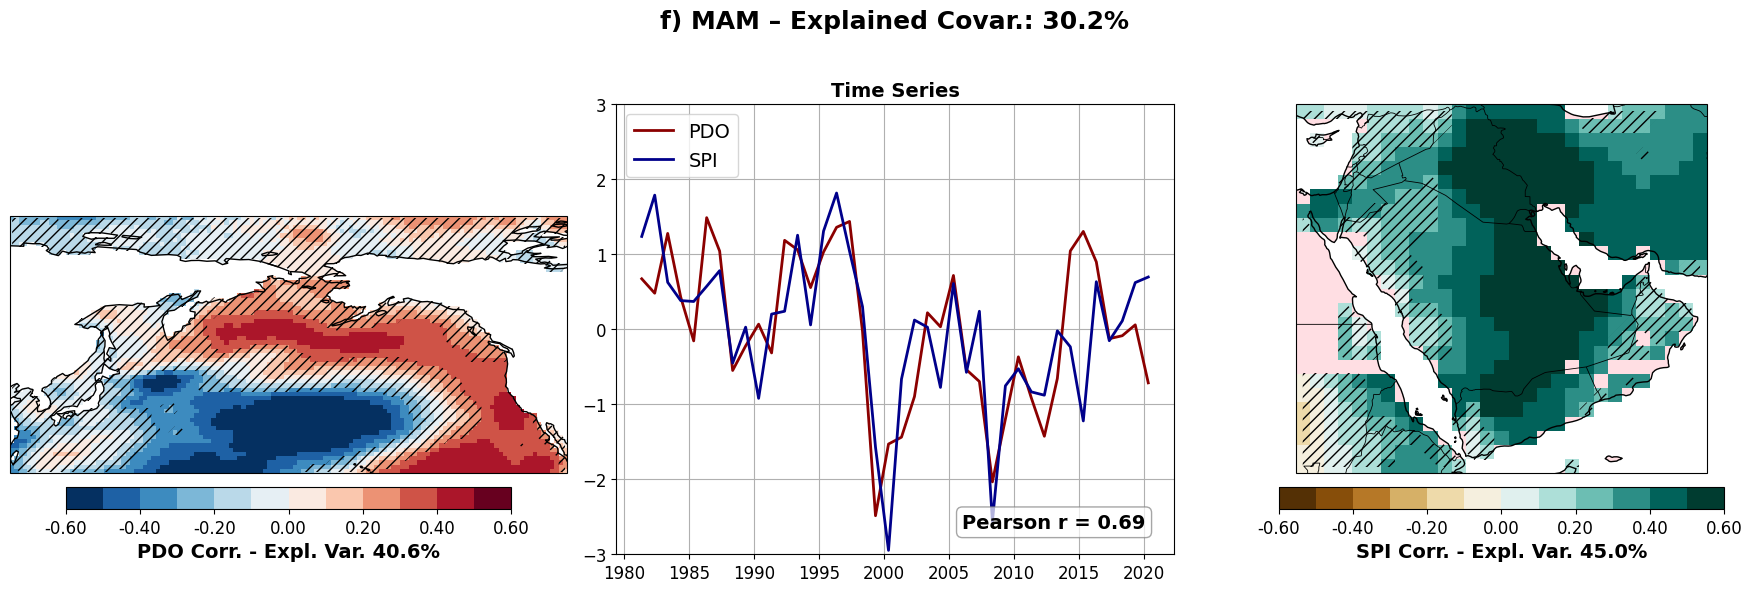

Processing season: MAM with detrending


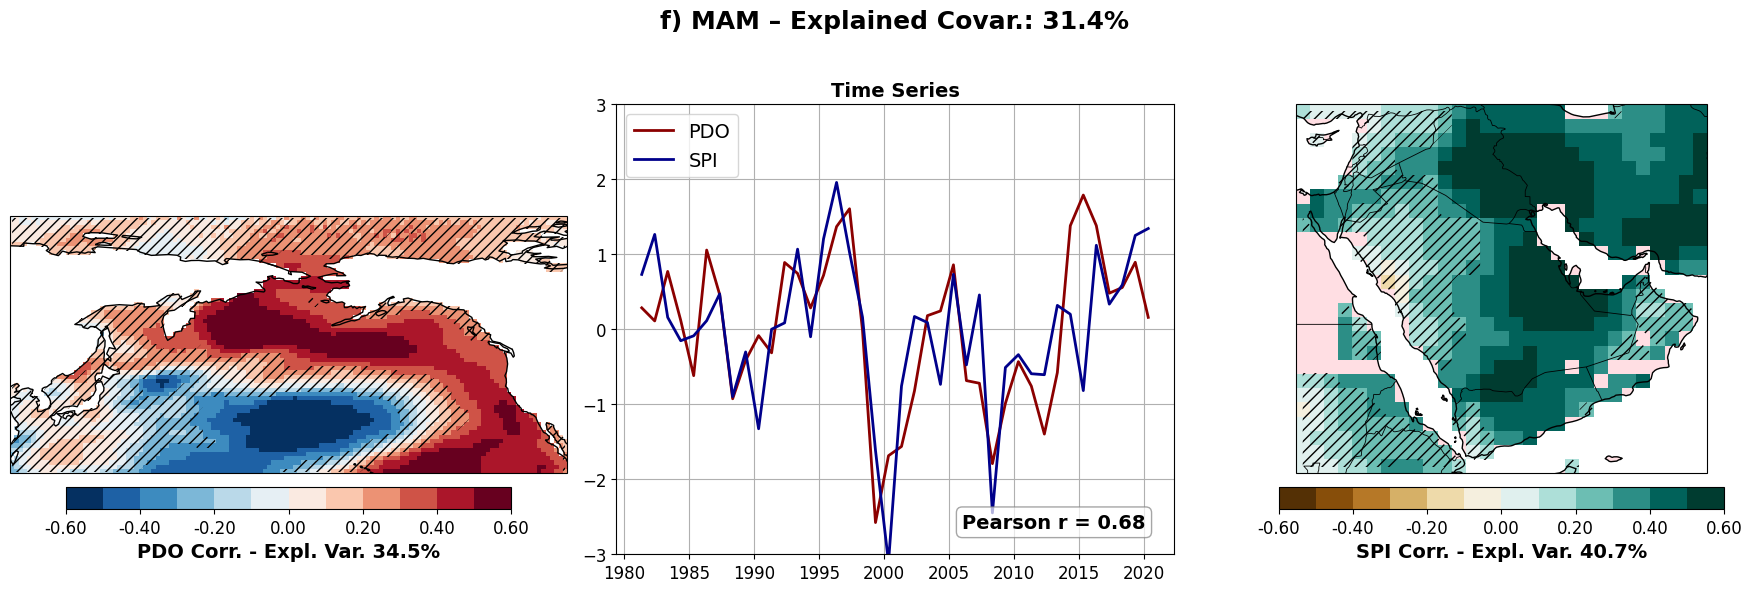

In [36]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']


for season, label in zip(seasons, labels):
    print(f"Processing season: {season} ")
    svd_analysis(pdo_sst.sst3m, spi, left_var='PDO',n_modes=3, month=season, label=label)
    print(f"Processing season: {season} with detrending")
    svd_analysis(pdo_sst.sst3m, spi, left_var='PDO', n_modes=3, month=season, label=label, detrend=True)